## Libraries 

In [157]:
from __future__ import annotations

import math
from dataclasses import dataclass
from typing import List, Dict, Tuple, Optional, Any

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt

## Data 

In [158]:
# =======================================
# Part 2 – Data Schema & Validation
# =======================================

# Example feature names – MODIFY to your real schema later
NUMERIC_FEATURES: List[str] = [
    "total_project_members",
    "average_members_per_team",
    "total_project_stories",
    "total_story_points",
    "average_story_points",
    "number_of_low_priority_stories",
    "number_of_medium_priority_stories",
    "number_of_high_priority_stories",
    "number_of_stories_in_progress",
    "number_of_stories_completed",
    "number_of_stories_todo",
    "number_of_stories_in_review",
    "number_of_different_teams",
    "number_of_testing_stories",
    "estimated_project_duration_in_days",
    "number_of_epics",
    "average_story_points_per_epic",
    "average_story_points_per_engineer",
    "average_seniority_level_per_engineer_in_days",
    "average_time_of_story_completion_in_hours",
    "average_time_of_stories_in_progress_in_hours",
]

CATEGORICAL_FEATURES: List[str] = []   # no categoricals in this synthetic data
LABEL_COL: str = "is_delayed"

ALL_FEATURES: List[str] = NUMERIC_FEATURES



def validate_schema(df: pd.DataFrame) -> None:
    """
    Validate that the incoming DataFrame has the expected columns.

    Raises
    ------
    ValueError
        If required columns are missing.
    """
    missing = [col for col in ALL_FEATURES + [LABEL_COL] if col not in df.columns]
    if missing:
        raise ValueError(f"DataFrame is missing required columns: {missing}")


In [159]:
# validate_schema(df)


## Model

In [160]:
# =======================================
# Part 3 – Preprocessing Utilities
# =======================================

class JiraPreprocessor:
    """
    Handles preprocessing of raw JIRA-like data:
      - imputes missing values
      - scales numeric features
      - one-hot encodes categorical features

    Produces a dense numpy feature matrix suitable for feeding into PyTorch.
    """

    def __init__(
        self,
        numeric_features: List[str],
        categorical_features: List[str],
        label_col: str,
    ) -> None:
        self.numeric_features = numeric_features
        self.categorical_features = categorical_features
        self.label_col = label_col

        # Build sklearn transformers
        numeric_transformer = Pipeline(
            steps=[
                ("imputer", SimpleImputer(strategy="median")),
                ("scaler", StandardScaler()),
            ]
        )

        categorical_transformer = Pipeline(
            steps=[
                ("imputer", SimpleImputer(strategy="most_frequent")),
                ("onehot", OneHotEncoder(handle_unknown="ignore")),
            ]
        )

        self.column_transformer: ColumnTransformer = ColumnTransformer(
            transformers=[
                ("num", numeric_transformer, self.numeric_features),
                ("cat", categorical_transformer, self.categorical_features),
            ]
        )
        self._fitted: bool = False

    def fit(self, df: pd.DataFrame) -> "JiraPreprocessor":
        """
        Fit the preprocessing pipeline on the DataFrame (features only).

        Parameters
        ----------
        df : pd.DataFrame
            Input data containing all features and the label column.

        Returns
        -------
        JiraPreprocessor
            The fitted instance (for chaining).
        """
        X = df[self.numeric_features + self.categorical_features]
        self.column_transformer.fit(X)
        self._fitted = True
        return self

    def transform(self, df: pd.DataFrame) -> Tuple[np.ndarray, np.ndarray]:
        """
        Transform the DataFrame into (X, y).

        Parameters
        ----------
        df : pd.DataFrame
            Input data containing all features and the label column.

        Returns
        -------
        X : np.ndarray, shape (n_samples, n_features_transformed)
            Preprocessed feature matrix.
        y : np.ndarray, shape (n_samples,)
            Binary labels (0 or 1).
        """
        if not self._fitted:
            raise RuntimeError("JiraPreprocessor must be fitted before calling transform().")

        X_raw = df[self.numeric_features + self.categorical_features]
        X = self.column_transformer.transform(X_raw)
        if not isinstance(X, np.ndarray):
            # OneHotEncoder may return scipy sparse; convert to dense
            X = X.toarray()

        y = df[self.label_col].astype(float).to_numpy()
        return X, y

    def fit_transform(self, df: pd.DataFrame) -> Tuple[np.ndarray, np.ndarray]:
        """
        Convenience wrapper to fit and transform in one step.
        """
        return self.fit(df).transform(df)


In [161]:
# =======================================
# Part 4 – Torch Dataset & DataLoaders
# =======================================

class RiskDataset(Dataset):
    """
    Simple PyTorch Dataset wrapper for supervised binary classification.

    Stores:
      - feature matrix X (numpy)
      - labels y (numpy)
    """

    def __init__(self, X: np.ndarray, y: np.ndarray) -> None:
        assert len(X) == len(y), "X and y must have the same number of samples."
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32).view(-1, 1)

    def __len__(self) -> int:
        return self.X.shape[0]

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor]:
        return self.X[idx], self.y[idx]


def build_dataloaders(
    X: np.ndarray,
    y: np.ndarray,
    batch_size: int = 64,
    val_size: float = 0.2,
    random_state: int = 42,
) -> Tuple[DataLoader, DataLoader]:
    """
    Split data into train/val and return DataLoaders.

    Parameters
    ----------
    X : np.ndarray
        Feature matrix.
    y : np.ndarray
        Labels.
    batch_size : int, optional
        Batch size for training and validation, by default 64.
    val_size : float, optional
        Proportion reserved for validation, by default 0.2.
    random_state : int, optional
        Random seed for reproducible splits, by default 42.

    Returns
    -------
    train_loader : DataLoader
    val_loader   : DataLoader
    """
    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=val_size, random_state=random_state, stratify=y
    )

    train_dataset = RiskDataset(X_train, y_train)
    val_dataset = RiskDataset(X_val, y_val)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader


In [162]:
# =======================================
# Part 5 – Bayesian-style NN (MC Dropout)
# =======================================

class BayesianDropoutMLP(nn.Module):
    """
    Feedforward neural network with Dropout layers, usable as a
    Bayesian approximation via Monte Carlo dropout.

    For binary classification:
      - outputs raw logits
      - use BCEWithLogitsLoss during training
      - apply sigmoid() to logits for probabilities
    """

    def __init__(
        self,
        input_dim: int,
        hidden_dims: List[int] = [64, 64],
        dropout_p: float = 0.2,
    ) -> None:
        super().__init__()
        layers: List[nn.Module] = []
        prev_dim = input_dim

        for h in hidden_dims:
            layers.append(nn.Linear(prev_dim, h))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(p=dropout_p))
            prev_dim = h

        self.feature_extractor = nn.Sequential(*layers)
        self.output_layer = nn.Linear(prev_dim, 1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass through the network.

        Parameters
        ----------
        x : torch.Tensor, shape (batch_size, input_dim)

        Returns
        -------
        logits : torch.Tensor, shape (batch_size, 1)
            Unnormalized log-odds for the positive class.
        """
        h = self.feature_extractor(x)
        logits = self.output_layer(h)
        return logits


In [163]:
# =======================================
# Part 6 – Training & Evaluation
# =======================================

@dataclass
class TrainingConfig:
    n_epochs: int = 50
    lr: float = 1e-3
    weight_decay: float = 1e-4   # L2 regularization
    device: str = "cuda" if torch.cuda.is_available() else "cpu"
    print_every: int = 5


def train_one_epoch(
    model: nn.Module,
    dataloader: DataLoader,
    optimizer: torch.optim.Optimizer,
    criterion: nn.Module,
    device: str,
) -> float:
    """
    Train the model for a single epoch.

    Returns
    -------
    avg_loss : float
        Average training loss across batches.
    """
    model.train()
    running_loss = 0.0
    n_batches = 0

    for X_batch, y_batch in dataloader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        optimizer.zero_grad()
        logits = model(X_batch)
        loss = criterion(logits, y_batch)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        n_batches += 1

    return running_loss / max(n_batches, 1)


def evaluate(
    model: nn.Module,
    dataloader: DataLoader,
    criterion: nn.Module,
    device: str,
) -> Tuple[float, float]:
    """
    Evaluate the model on a validation set.

    Returns
    -------
    avg_loss : float
    accuracy : float
    """
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    n_batches = 0

    with torch.no_grad():
        for X_batch, y_batch in dataloader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            logits = model(X_batch)
            loss = criterion(logits, y_batch)
            probs = torch.sigmoid(logits)
            preds = (probs >= 0.5).float()

            running_loss += loss.item()
            n_batches += 1

            correct += (preds == y_batch).sum().item()
            total += y_batch.numel()

    avg_loss = running_loss / max(n_batches, 1)
    accuracy = correct / max(total, 1)
    return avg_loss, accuracy


def train_model(
    model: nn.Module,
    train_loader: DataLoader,
    val_loader: DataLoader,
    config: TrainingConfig,
) -> Dict[str, List[float]]:
    """
    Full training loop with validation tracking.

    Parameters
    ----------
    model : nn.Module
        The neural network.
    train_loader : DataLoader
    val_loader   : DataLoader
    config       : TrainingConfig

    Returns
    -------
    history : dict
        Training history with loss/accuracy curves.
    """
    device = config.device
    model.to(device)

    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(
        model.parameters(), lr=config.lr, weight_decay=config.weight_decay
    )

    history = {
        "train_loss": [],
        "val_loss": [],
        "val_acc": [],
    }

    for epoch in range(1, config.n_epochs + 1):
        train_loss = train_one_epoch(model, train_loader, optimizer, criterion, device)
        val_loss, val_acc = evaluate(model, val_loader, criterion, device)

        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        if epoch % config.print_every == 0 or epoch == 1 or epoch == config.n_epochs:
            print(
                f"Epoch {epoch:03d} | "
                f"Train Loss: {train_loss:.4f} | "
                f"Val Loss: {val_loss:.4f} | "
                f"Val Acc: {val_acc:.4f}"
            )

    return history


In [164]:
# =======================================
# Part 7 – Monte Carlo Prediction & Risk
# =======================================

def mc_predict_proba(
    model: nn.Module,
    x: np.ndarray,
    n_samples: int = 1000,
    device: str = "cuda" if torch.cuda.is_available() else "cpu",
) -> Dict[str, Any]:
    """
    Monte Carlo dropout prediction for a single example.

    Parameters
    ----------
    model : nn.Module
        Trained BayesianDropoutMLP model.
    x : np.ndarray, shape (n_features,)
        Single preprocessed feature vector.
    n_samples : int
        Number of stochastic forward passes.
    device : str
        'cpu' or 'cuda'.

    Returns
    -------
    result : dict
        {
          "probs": np.ndarray of shape (n_samples,),
          "mean": float,
          "std": float,
          "ci_5": float,
          "ci_95": float
        }
    """
    model.to(device)

    # Ensure x is 2D: (1, n_features)
    if x.ndim == 1:
        x = x.reshape(1, -1)

    x_tensor = torch.tensor(x, dtype=torch.float32).to(device)

    model.train()  # IMPORTANT: keep dropout active at inference for MC
    probs_list = []

    with torch.no_grad():
        for _ in range(n_samples):
            logits = model(x_tensor)
            prob = torch.sigmoid(logits).cpu().numpy().flatten()[0]
            probs_list.append(prob)

    probs = np.array(probs_list)
    mean = float(probs.mean())
    std = float(probs.std())
    ci_5 = float(np.percentile(probs, 5))
    ci_95 = float(np.percentile(probs, 95))

    return {
        "probs": probs,
        "mean": mean,
        "std": std,
        "ci_5": ci_5,
        "ci_95": ci_95,
    }


def categorize_risk(mean_prob: float) -> str:
    """
    Map the mean probability to a discrete risk category.

    You can tune thresholds as needed.
    """
    if mean_prob < 0.33:
        return "Low"
    elif mean_prob < 0.66:
        return "Medium"
    else:
        return "High"


In [165]:
from dataclasses import dataclass, field


In [166]:
# =======================================
# Part 8 – RiskEngine (End-to-End Wrapper)
# =======================================

@dataclass
class RiskEngineConfig:
    hidden_dims: List[int] = (64, 64)
    dropout_p: float = 0.2
    batch_size: int = 64
    val_size: float = 0.2
    training: TrainingConfig = field(default_factory=TrainingConfig)
    n_mc_samples: int = 1000


class RiskEngine:
    """
    End-to-end risk engine:
      - preprocesses JIRA-like data
      - trains BayesianDropoutMLP
      - provides MC dropout-based predictions with uncertainty
    """

    def __init__(self, config: Optional[RiskEngineConfig] = None) -> None:
        self.config = config or RiskEngineConfig()
        self.preprocessor = JiraPreprocessor(
            numeric_features=NUMERIC_FEATURES,
            categorical_features=CATEGORICAL_FEATURES,
            label_col=LABEL_COL,
        )
        self.model: Optional[BayesianDropoutMLP] = None

    def fit(self, df: pd.DataFrame) -> Dict[str, List[float]]:
        """
        Fit the engine on a labeled DataFrame.

        Parameters
        ----------
        df : pd.DataFrame
            Data containing features + label.

        Returns
        -------
        history : dict
            Training history from train_model.
        """
        # ---- Diagnostics: high-level dataset info ----
        print("=== [RiskEngine.fit] Starting training ===")
        print(f"[RiskEngine.fit] Incoming df shape: {df.shape}")
        print(f"[RiskEngine.fit] Columns: {list(df.columns)}")

        validate_schema(df)
        pos_rate = df[LABEL_COL].mean()
        print(f"[RiskEngine.fit] Positive rate ({LABEL_COL}==1): {pos_rate:.3f}")

        # Preprocess and split into train/val loaders
        X, y = self.preprocessor.fit_transform(df)
        print(f"[RiskEngine.fit] Transformed X shape: {X.shape}, y shape: {y.shape}")

        train_loader, val_loader = build_dataloaders(
            X, y,
            batch_size=self.config.batch_size,
            val_size=self.config.val_size,
        )

        print("[RiskEngine.fit] "
              f"Train batches: {len(train_loader)}, "
              f"Val batches: {len(val_loader)}")

        # Initialize model
        input_dim = X.shape[1]
        print(f"[RiskEngine.fit] Input dimension after encoding: {input_dim}")
        self.model = BayesianDropoutMLP(
            input_dim=input_dim,
            hidden_dims=list(self.config.hidden_dims),
            dropout_p=self.config.dropout_p,
        )

        # Train model
        history = train_model(
            model=self.model,
            train_loader=train_loader,
            val_loader=val_loader,
            config=self.config.training,
        )

        print("=== [RiskEngine.fit] Training complete ===")
        return history


    def _check_model_ready(self) -> None:
        if self.model is None:
            raise RuntimeError("RiskEngine model is not trained yet. Call fit() first.")

    def predict_row(self, row: pd.Series) -> Dict[str, Any]:
        """
        Run the full MC dropout prediction for a single row (pd.Series).

        Parameters
        ----------
        row : pd.Series
            One issue's features + label (label will be ignored if present).

        Returns
        -------
        result : dict
            {
              "mean_prob": float,
              "std": float,
              "ci_5": float,
              "ci_95": float,
              "risk_category": str,
              "all_samples": np.ndarray
            }
        """
        self._check_model_ready()

        # Convert Series -> DataFrame for preprocessing
        df_row = row.to_frame().T

        # Note: transform() expects label_col; if label missing here, you can work
        # around it by temporarily adding a dummy label.
        if LABEL_COL not in df_row.columns:
            df_row[LABEL_COL] = 0  # dummy label not used in prediction

        X_row, _ = self.preprocessor.transform(df_row)
        mc_result = mc_predict_proba(
            model=self.model,
            x=X_row[0],
            n_samples=self.config.n_mc_samples,
            device=self.config.training.device,
        )

        risk_category = categorize_risk(mc_result["mean"])

        return {
            "mean_prob": mc_result["mean"],
            "std": mc_result["std"],
            "ci_5": mc_result["ci_5"],
            "ci_95": mc_result["ci_95"],
            "risk_category": risk_category,
            "all_samples": mc_result["probs"],
        }

    def predict_dataframe(self, df_new: pd.DataFrame) -> pd.DataFrame:
        """
        Run MC predictions for every row in a new DataFrame.

        NOTE: This can be slow if n_mc_samples is large and df_new is big.
        Typically you'd call predict_row() for a single issue the user enters.

        Returns
        -------
        df_out : pd.DataFrame
            Input df_new with extra columns:
              - pred_mean_prob
              - pred_std
              - pred_ci_5
              - pred_ci_95
              - pred_risk_category
        """
        self._check_model_ready()

        # Ensure label column exists for transform(); use dummy if needed
        df_work = df_new.copy()
        if LABEL_COL not in df_work.columns:
            df_work[LABEL_COL] = 0

        X_all, _ = self.preprocessor.transform(df_work)

        records = []
        for i in range(len(df_work)):
            mc_result = mc_predict_proba(
                model=self.model,
                x=X_all[i],
                n_samples=self.config.n_mc_samples,
                device=self.config.training.device,
            )
            records.append(
                {
                    "pred_mean_prob": mc_result["mean"],
                    "pred_std": mc_result["std"],
                    "pred_ci_5": mc_result["ci_5"],
                    "pred_ci_95": mc_result["ci_95"],
                    "pred_risk_category": categorize_risk(mc_result["mean"]),
                }
            )

        preds_df = pd.DataFrame.from_records(records, index=df_work.index)
        return pd.concat([df_new.reset_index(drop=True), preds_df.reset_index(drop=True)], axis=1)


## Diagnostic of model engine

In [167]:
# =======================================
# Part 9 – Diagnostics Utilities
# =======================================

def describe_dataset(df: pd.DataFrame) -> None:
    """
    Print basic diagnostics about the dataset:
      - shape
      - dtypes
      - label distribution
      - head
    """
    print("=== Dataset Overview ===")
    print(f"Shape: {df.shape}")
    print("\nDtypes:")
    print(df.dtypes)
    if LABEL_COL in df.columns:
        print(f"\nLabel column: {LABEL_COL}")
        print(df[LABEL_COL].value_counts(normalize=True).rename("proportion"))
    print("\nHead:")
    print(df.head())


def evaluate_engine_on_full_df(engine: RiskEngine, df: pd.DataFrame) -> Dict[str, float]:
    """
    Evaluate a trained engine on a labeled DataFrame (full set).

    Computes accuracy, ROC AUC, and prints a confusion matrix + classification report.
    """
    engine._check_model_ready()

    # Use the already-fitted preprocessor (NO refitting)
    X, y = engine.preprocessor.transform(df)
    y_true = y.astype(int)

    device = engine.config.training.device
    model = engine.model.to(device)
    model.eval()

    with torch.no_grad():
        X_t = torch.tensor(X, dtype=torch.float32).to(device)
        logits = model(X_t)
        probs = torch.sigmoid(logits).cpu().numpy().flatten()

    preds = (probs >= 0.5).astype(int)

    acc = float((preds == y_true).mean())
    try:
        auc = float(roc_auc_score(y_true, probs))
    except ValueError:
        auc = float("nan")  # happens if only 1 class present

    print("=== Evaluation on Full Dataset ===")
    print(f"Accuracy: {acc:.3f}")
    print(f"ROC AUC : {auc:.3f}")
    print("\nConfusion matrix:")
    print(confusion_matrix(y_true, preds))
    print("\nClassification report:")
    print(classification_report(y_true, preds, digits=3))

    return {"accuracy": acc, "auc": auc}


def plot_training_history(history: Dict[str, List[float]]) -> None:
    """
    Plot training/validation loss and validation accuracy over epochs.
    """
    epochs = range(1, len(history["train_loss"]) + 1)

    plt.figure(figsize=(10, 4))

    # Loss curves
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history["train_loss"], label="Train loss")
    plt.plot(epochs, history["val_loss"], label="Val loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training vs Validation Loss")
    plt.legend()

    # Accuracy curve
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history["val_acc"], label="Val accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Validation Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()


def plot_mc_distribution(result: Dict[str, Any]) -> None:
    """
    Visualize the Monte Carlo probability distribution for a single prediction.

    Expects the dict returned by engine.predict_row(...).
    """
    probs = result["all_samples"]

    plt.figure(figsize=(6, 4))
    plt.hist(probs, bins=30, density=True)
    plt.axvline(result["mean_prob"], linestyle="--", label=f"mean={result['mean_prob']:.2f}")
    plt.axvline(result["ci_5"], linestyle=":", label=f"5%={result['ci_5']:.2f}")
    plt.axvline(result["ci_95"], linestyle=":", label=f"95%={result['ci_95']:.2f}")
    plt.xlabel("Predicted probability")
    plt.ylabel("Density")
    plt.title(f"MC Dropout Distribution (risk={result['risk_category']})")
    plt.legend()
    plt.show()


## Training model

=== Dataset Overview ===
Shape: (50000, 22)

Dtypes:
total_project_members                             int64
average_members_per_team                        float64
total_project_stories                             int64
total_story_points                                int64
average_story_points                            float64
number_of_low_priority_stories                    int64
number_of_medium_priority_stories                 int64
number_of_high_priority_stories                   int64
number_of_stories_in_progress                     int64
number_of_stories_completed                       int64
number_of_stories_todo                            int64
number_of_stories_in_review                       int64
number_of_different_teams                         int64
number_of_testing_stories                         int64
estimated_project_duration_in_days              float64
number_of_epics                                   int64
average_story_points_per_epic                   flo

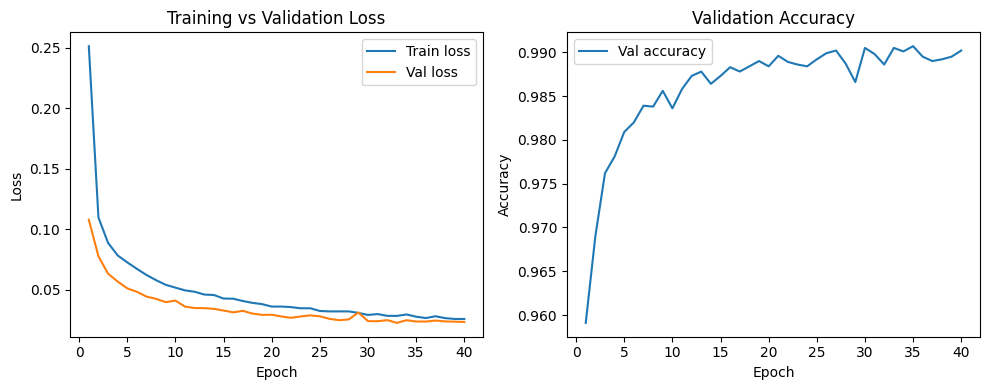

=== Evaluation on Full Dataset ===
Accuracy: 0.994
ROC AUC : 1.000

Confusion matrix:
[[32508   164]
 [  140 17188]]

Classification report:
              precision    recall  f1-score   support

           0      0.996     0.995     0.995     32672
           1      0.991     0.992     0.991     17328

    accuracy                          0.994     50000
   macro avg      0.993     0.993     0.993     50000
weighted avg      0.994     0.994     0.994     50000


Global metrics: {'accuracy': 0.99392, 'auc': 0.9998242079222975}

Single project prediction (summary):
mean_prob: 0.9999470710754395
std: 0.00016603348194621503
ci_5: 0.9997681140899658
ci_95: 0.9999995231628418
risk_category: High


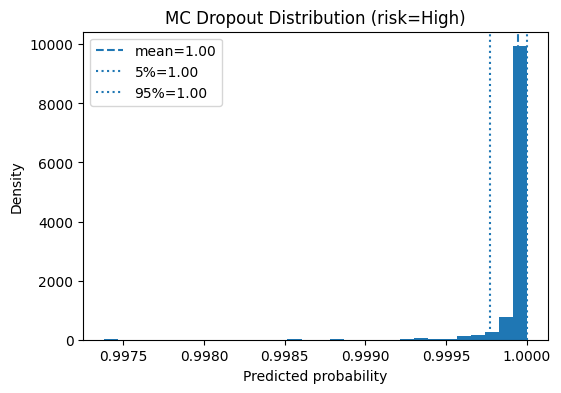

In [168]:
# =======================================
# Train + Evaluate Risk Engine
# =======================================

df = pd.read_csv("jira_synthetic_projects.csv")

describe_dataset(df)
validate_schema(df)

engine_config = RiskEngineConfig(
    hidden_dims=[128, 64],      # a bit wider
    dropout_p=0.2,
    batch_size=128,
    val_size=0.2,
    training=TrainingConfig(
        n_epochs=40,            # a bit longer
        lr=5e-4,                # slightly smaller LR
        weight_decay=1e-4,
        device="cuda" if torch.cuda.is_available() else "cpu",
        print_every=5,
    ),
    n_mc_samples=500,
)
engine = RiskEngine(config=engine_config)
history = engine.fit(df)

plot_training_history(history)
metrics = evaluate_engine_on_full_df(engine, df)
print("\nGlobal metrics:", metrics)

# Demo a single project prediction
sample_row = df.sample(1, random_state=0).iloc[0]
result = engine.predict_row(sample_row)
print("\nSingle project prediction (summary):")
for k, v in result.items():
    if k != "all_samples":
        print(f"{k}: {v}")

plot_mc_distribution(result)


In [169]:
from sklearn.linear_model import LogisticRegression

X, y = engine.preprocessor.transform(df)
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)

probs = log_reg.predict_proba(X_val)[:, 1]
preds = (probs >= 0.5).astype(int)


In [170]:
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report, roc_curve

# 1) Basic metrics for plain 0.5 threshold
log_acc = accuracy_score(y_val, preds)
log_auc = roc_auc_score(y_val, probs)

print("=== Logistic Regression (baseline) ===")
print(f"Accuracy (thr=0.50): {log_acc:.3f}")
print(f"ROC AUC            : {log_auc:.3f}")
print("\nConfusion matrix:")
print(confusion_matrix(y_val, preds))
print("\nClassification report:")
print(classification_report(y_val, preds, digits=3))

# 2) (Optional) Tune the decision threshold to maximize accuracy
fpr, tpr, thresholds = roc_curve(y_val, probs)
youden = tpr - fpr                       # Youden's J statistic
best_idx = youden.argmax()
best_thresh = thresholds[best_idx]

preds_opt = (probs >= best_thresh).astype(int)
log_acc_opt = accuracy_score(y_val, preds_opt)

print("\n=== Threshold tuning ===")
print(f"Best threshold by Mason: {best_thresh:.3f}")
print(f"Accuracy (thr={best_thresh:.3f}): {log_acc_opt:.3f}")


=== Logistic Regression (baseline) ===
Accuracy (thr=0.50): 0.962
ROC AUC            : 0.994

Confusion matrix:
[[6343  191]
 [ 186 3280]]

Classification report:
              precision    recall  f1-score   support

         0.0      0.972     0.971     0.971      6534
         1.0      0.945     0.946     0.946      3466

    accuracy                          0.962     10000
   macro avg      0.958     0.959     0.958     10000
weighted avg      0.962     0.962     0.962     10000


=== Threshold tuning ===
Best threshold by Mason: 0.362
Accuracy (thr=0.362): 0.958
